# Semivariogram models

`Pyinterpolate` has a few theoretical functions that can be fit into experimental semivariances. Those functions are usually pre-defined because we cannot use any mapping. A function must be positive because we are modeling variance. Technically speaking, a function must be positive definite (covariances), and variogram has to be conditionally negative definite (M. Armstrong, Basic Linear Geostatistics, Springer 1998, page 35).

Theory aside, you will probably use built-in semivariogram models. We will check all those functions in this lesson. Moreover, we will learn:

- how to create an artificial surface with `scipy`
- which variogram models are available for modeling
- what are the differences between the mapping functions


## Prerequisites

- **Domain**:
  - semivariance and covariance functions
- **Package**:
  - installation
- **Programming**:
  - Python basics

## Table of contents

1. Create random surface
2. Calculate the experimental variogram
3. Fit variogram models
4. Compare variogram models

In [1]:
import numpy as np
from scipy.signal import convolve2d
from scipy.sparse import coo_matrix

from pyinterpolate import build_experimental_variogram, build_theoretical_variogram

import matplotlib.pyplot as plt

## Chapter 1: Create random surface

We create the artificial surface. We choose a simulated area instead of real-world observations because we have more control over variogram parameters. Thus, we will know what is compared when we model semivariogram with different functions. We should limit the number of unknowns in our dataset to a bare minimum. But don't be disappointed! Our surface won't be *boring* because we will generate it from an exciting function named [logistic_map](https://en.wikipedia.org/wiki/Logistic_map). It is the polynomial mapping that, for some parameters, presents chaotic behavior.

**Logistic map** is a recurrent relation of the form:

$$x_{n+1} = rx_{n}(1-x_{n}),$$

Where:
- $x$: is a mapped value at a step $n$ or $n+1$. Its state depends only on the previous step and initial set of parameters, $x \in [0, 1]$.
- $r$: is a special parameter, and its value leads to the different behavior of a system. For us, the most important is a set of possible $r$ values within limits $[3.5, 4]$ where the system has chaotic behavior [more](https://en.wikipedia.org/wiki/Logistic_map#Behavior_dependent_on_r).

We will use the `generate_logistic_map` function that takes three parameters:

- `r`: the same as $r$ from the **logistic map** system, we set it to **3.9**.
- `size`: the length of a generated sequence. It should be reasonably large to create a surface. We set it to **10k**.
- `initial_ratio`: initial `x` value between 0 and 1. We set it to **0.33**.

In [2]:
# Create logistic map

def generate_logistic_map(r: float, size: int, initial_ratio: float) -> np.ndarray:
    # rxn(1-xn)
    vals = [initial_ratio]
    for _ in range(size-1):
        new_val = r * vals[-1] * (1 - vals[-1])
        vals.append(new_val)
    return np.array(vals)

In [3]:
values = generate_logistic_map(3.9, 10000, 0.33)

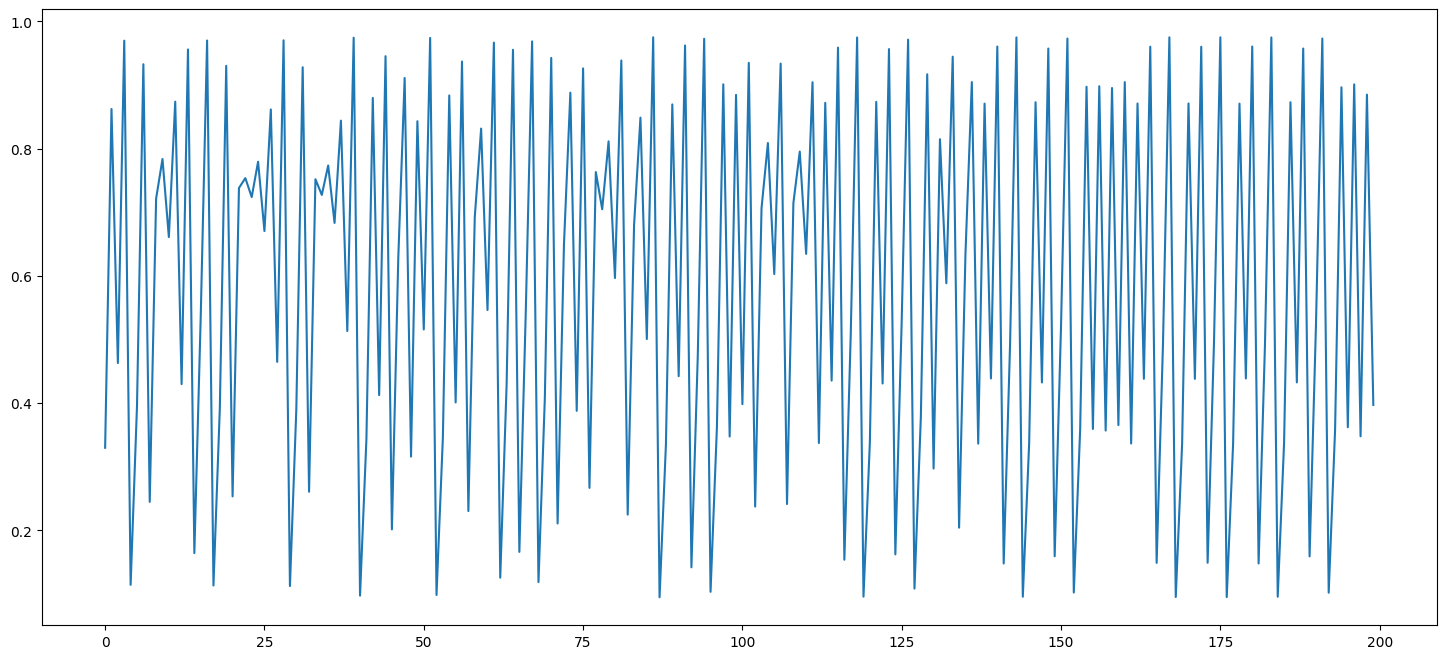

In [4]:
# At this point, our data is a 1-dimensional array and we can represent it as a signal

plt.figure(figsize=(18, 8))
plt.plot(values[0:200])
plt.show()

Let's reshape this signal into **2-D matrix**. This way, we create baseline surface for experiments.

In [5]:
surface = np.reshape(values, (100, 100))

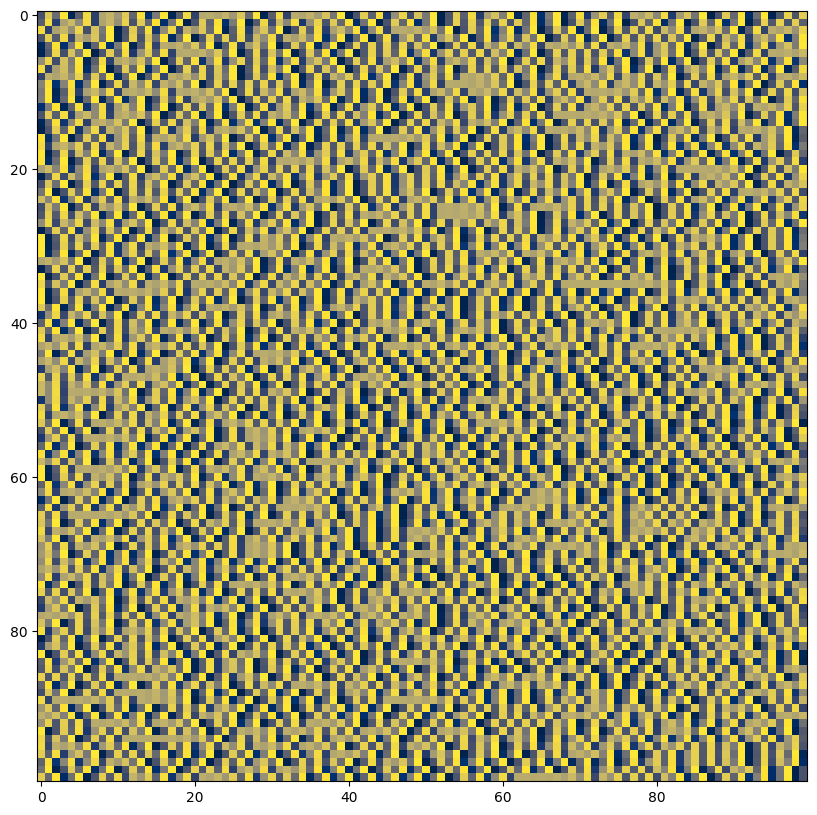

In [6]:
plt.figure(figsize=(10, 10))
plt.imshow(surface, cmap='cividis')
plt.show()

The spatial correlation of this structure is very weak. We can change it with a simple blur filter. Its size will be close to the **range** parameter! Blur filter averages pixel values within its range. In other words, it areas with correlated values. I set the filter size to seven (7) units, but you can set it smaller or larger for your experiments. You can apply it multiple times to get smoother areas, where values will be even more similar within the filter range.

In [7]:
# Slightly blur image with simple mean filter

mean_filter = np.ones(shape=(7, 7))

surf_blurred = convolve2d(surface, mean_filter, boundary='wrap')

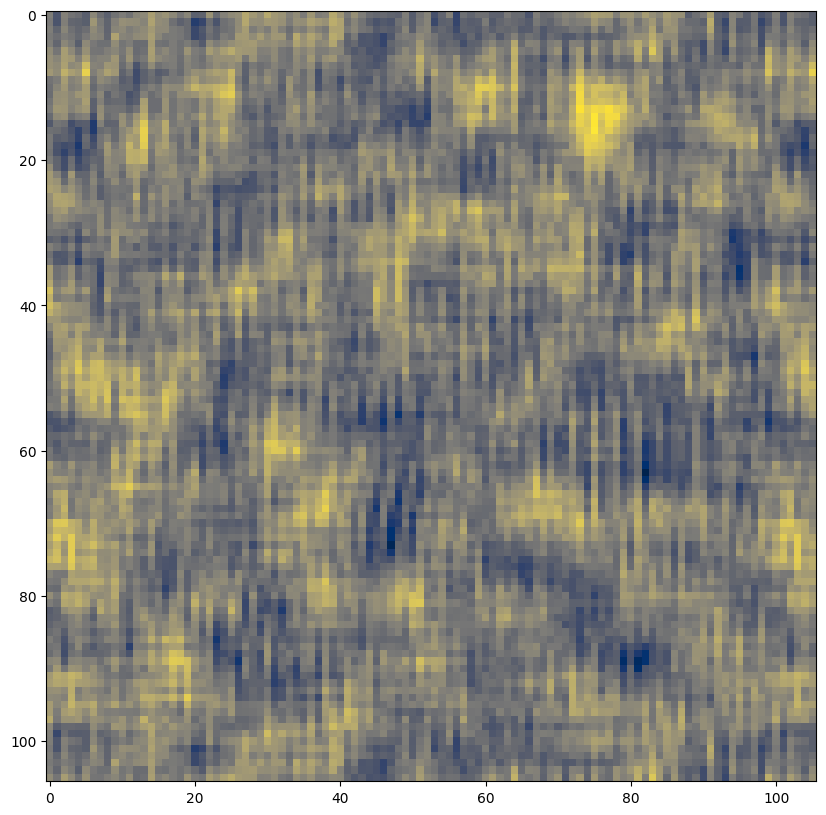

In [8]:
# And here we are! We have our artificial surface for testing purposes!

plt.figure(figsize=(10, 10))
plt.imshow(surf_blurred, cmap='cividis')
plt.show()

## Chapter 2: Calculate the experimental semivariogram

We must create the experimental variogram before we start comparing theoretical models. Our two-dimensional surface must be transformed into an array:

```
[
    [coordinate x1, coordinate y1, value1],
    [coordinate x2, coordinate y2, value2],
    [...],
]
```

The path to transform a 2D surface into pixel coordinates has two steps. In the first step, we use `scipy` to make a sparse representation of the surface, and in the second step, we use `numpy` to transform the sparse representation into an array.

In [9]:
# Transform data into x, y, val array

sparse_data = coo_matrix(surf_blurred)

In [10]:
# data, col, row == value, x, y

xyval = np.asarray([sparse_data.col, sparse_data.row, sparse_data.data]).T

We know the data - the effective range of correlation is set to seven units, because we set the mean filter to this size. 

With this knowledge, we will set `step_size` into 2 units and `max_range` into 20 (way above the actual maximum range, which is 7, but we show in this way how variograms behave at a large distance where there is no spatial correlation).

In [11]:
# Get experimental variogram

experimental = build_experimental_variogram(xyval, step_size=2, max_range=20)

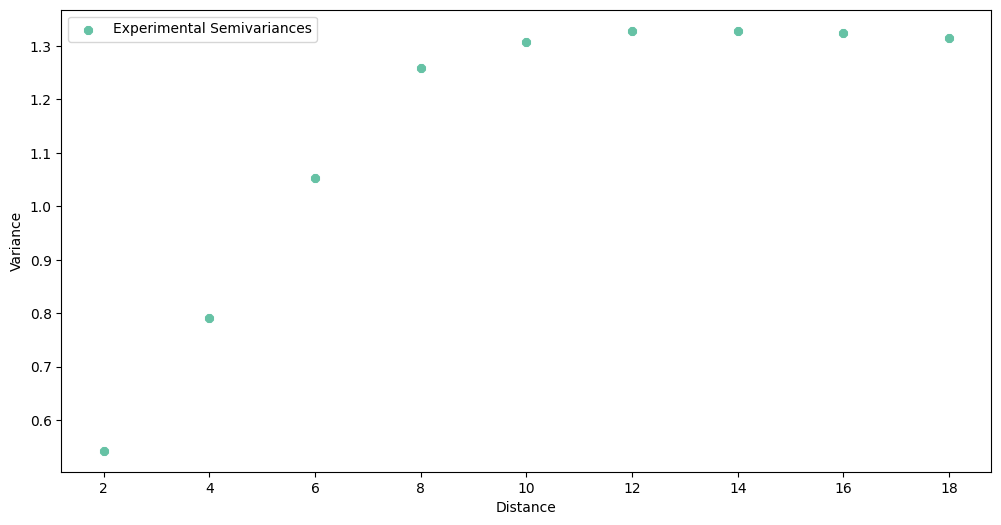

In [12]:
experimental.plot(covariance=False, variance=False)

After examining the plot, we can set the theoretical variogram parameters.

- **nugget** to `0`,
- **sill** to `1.3`,
- **range** to `8`.

We can create the theoretical variogram from scratch without calling the `build_theoretical_variogram()` function or the `TheoreticalVariogram` class. Those three parameters are all that we need for modeling.

In [13]:
# Set nugget, sill and range

_nugget = 0
_sill = 1.3
_range = 7

## Chapter 3: Fit variogram models

We have seven theoretical functions to model the experimental semivariances:

- circular
- cubic
- exponential
- gaussian
- linear
- power
- spherical

In [14]:
# Crete different models: circular, cubic, exponential, gaussian, linear, power, spherical

circular = build_theoretical_variogram(
    experimental_variogram=experimental,
    models_group='circular',
    nugget=_nugget,
    sill=_sill,
    rang=_range)

cubic = build_theoretical_variogram(
    experimental_variogram=experimental,
    models_group='cubic',
    nugget=_nugget,
    sill=_sill,
    rang=_range)

exponential = build_theoretical_variogram(
    experimental_variogram=experimental,
    models_group='exponential',
    nugget=_nugget,
    sill=_sill,
    rang=_range)

gaussian = build_theoretical_variogram(
    experimental_variogram=experimental,
    models_group='gaussian',
    nugget=_nugget,
    sill=_sill,
    rang=_range)

linear = build_theoretical_variogram(
    experimental_variogram=experimental,
    models_group='linear',
    nugget=_nugget,
    sill=_sill,
    rang=_range)

power = build_theoretical_variogram(
    experimental_variogram=experimental,
    models_group='power',
    nugget=_nugget,
    sill=_sill,
    rang=_range)

spherical = build_theoretical_variogram(
    experimental_variogram=experimental,
    models_group='spherical',
    nugget=_nugget,
    sill=_sill,
    rang=_range)

With all models calculated, let's take a look at their output. Before we jump into the last step, which model works optimally with the experimental variogram? (It is tricky question!)

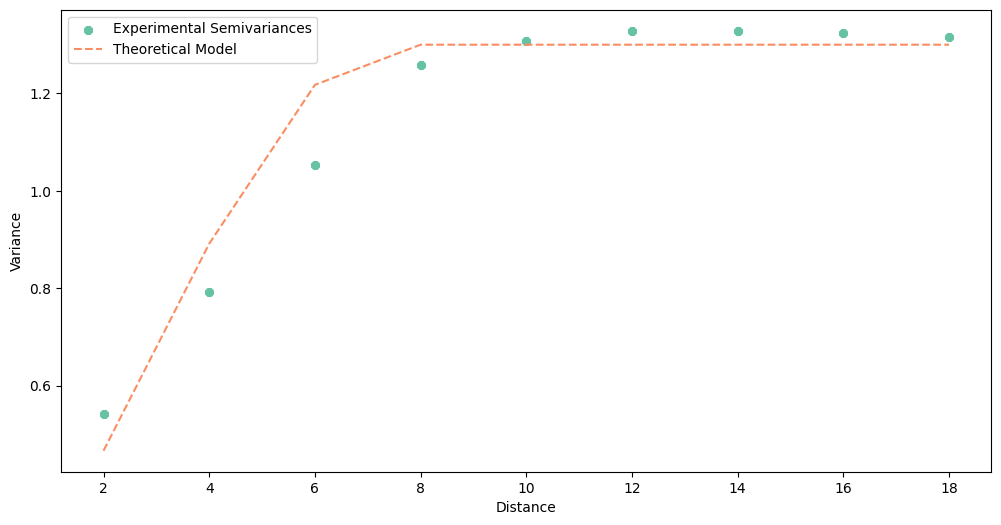

In [15]:
# Circular

circular.plot()

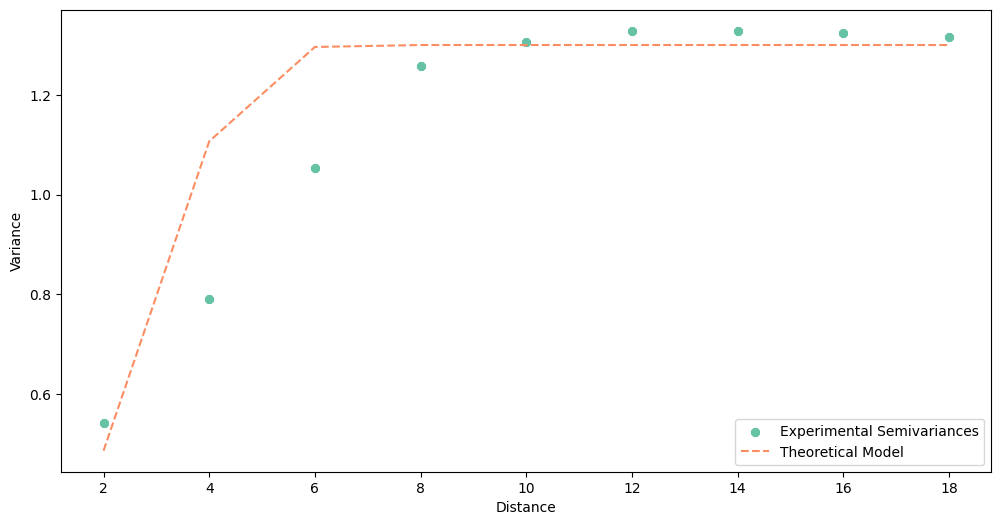

In [16]:
# Cubic

cubic.plot()

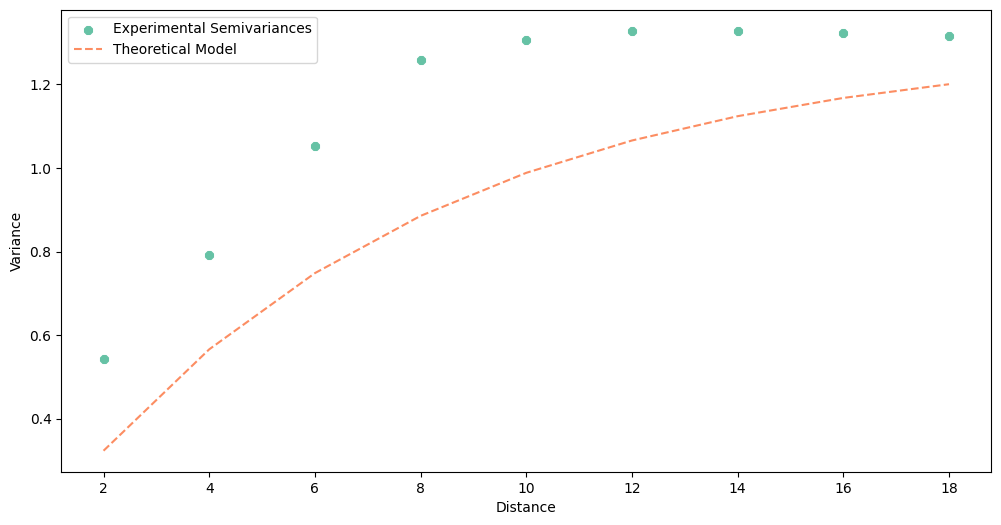

In [17]:
# exponential

exponential.plot()

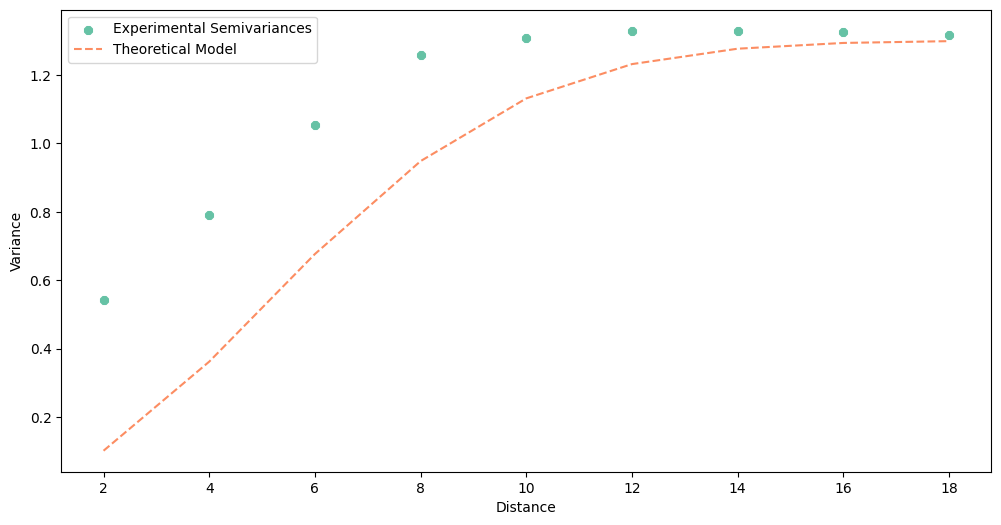

In [18]:
# Gaussian

gaussian.plot()

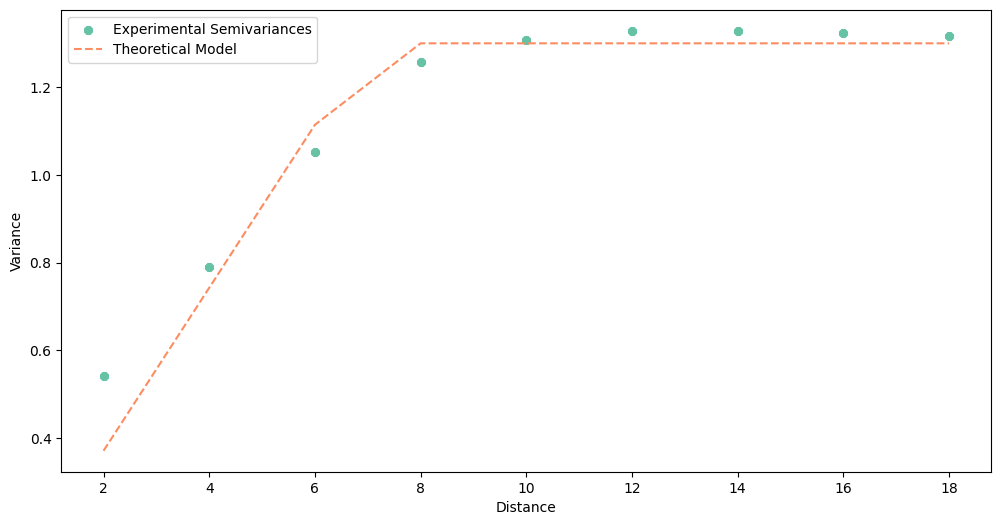

In [19]:
# linear

linear.plot()

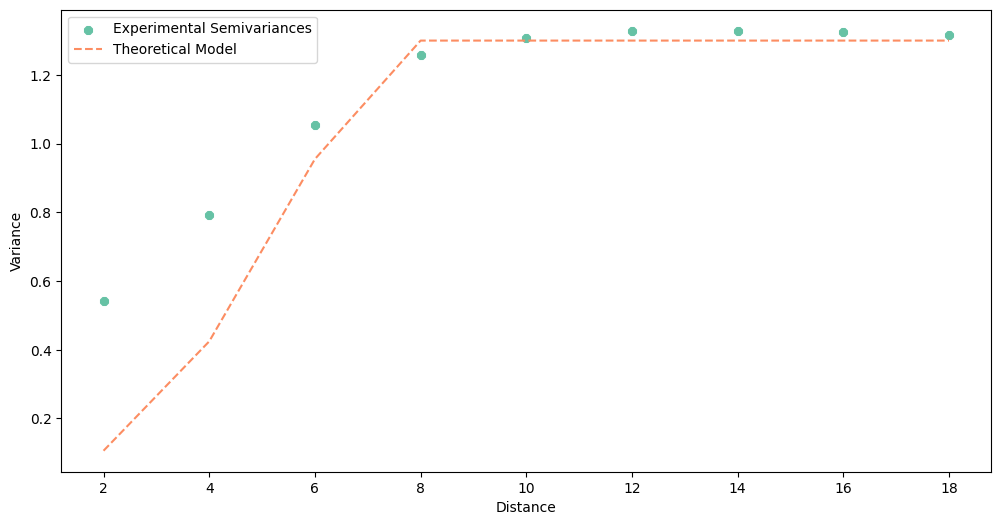

In [20]:
# power

power.plot()

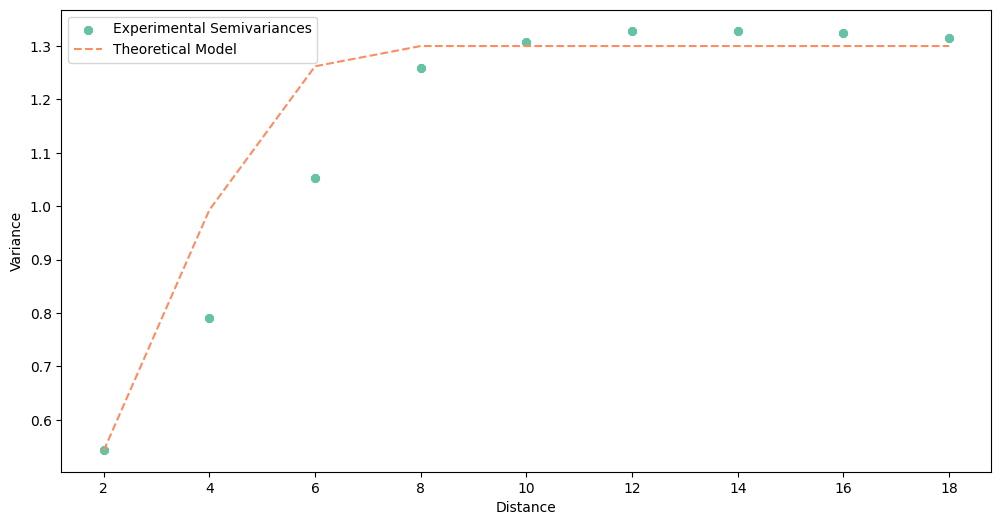

In [21]:
# spherical

spherical.plot()

What was your guess?

.
.
.

I hope, that you have chosen `circular` or `linear` model! But we should be careful with the final opinion and even more careful if we let the algorithm decide which model is the best based on the **root mean squared error metric** (RMSE). For us, the best model is always the model that has the best fit for the closest distances. A model with low RMSE may be "great" with distances from 10 to 18... which oscillate around the sill of our data, and point pairs at those distances useless for weighting (weight is constant from some distance).

## Chapter 4: Compare variogram models

The last part is a comparison of variogram models. We will still use our "own eyes" to decide which model is the best, but this time we will plot all of them in a single plot.

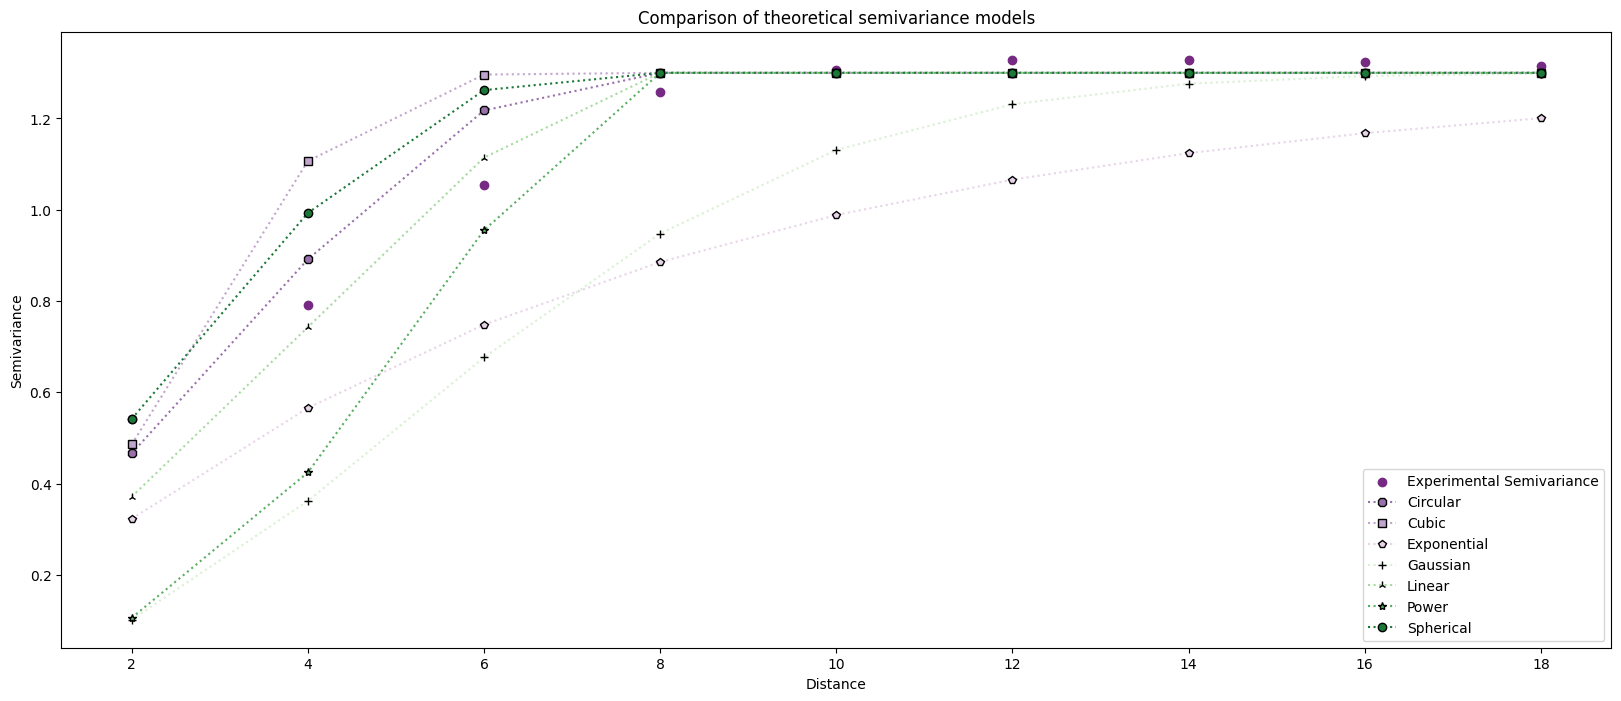

In [22]:
# Plot ALL models

_lags = circular.lags

plt.figure(figsize=(20, 8))
plt.scatter(_lags, experimental.semivariances, color='#762a83')
plt.plot(_lags, circular.yhat, ':8', color='#9970ab', mec='black')
plt.plot(_lags, cubic.yhat, ':s', color='#c2a5cf', mec='black')
plt.plot(_lags, exponential.yhat, ':p', color='#e7d4e8', mec='black')
plt.plot(_lags, gaussian.yhat, ':+', color='#d9f0d3', mec='black')
plt.plot(_lags, linear.yhat, ':2', color='#a6dba0', mec='black')
plt.plot(_lags, power.yhat, ':*', color='#5aae61', mec='black')
plt.plot(_lags, spherical.yhat, ':o', color='#1b7837', mec='black')
plt.title('Comparison of theoretical semivariance models')
plt.legend(['Experimental Semivariance',
            'Circular',
            'Cubic',
            'Exponential',
            'Gaussian',
            'Linear',
            'Power',
            'Spherical'])
plt.xlabel('Distance')
plt.ylabel('Semivariance')
plt.show()

We observe that the lowest distance from a modeled value to the experimental curve at small distances has linear model.

---

## Changelog

| Date       | Changes                                      | Author                           |
|------------|----------------------------------------------|----------------------------------|
| 2025-02-28 | Tutorial has been adapted to the 1.0 release | @SimonMolinsky (Szymon Moliński) |